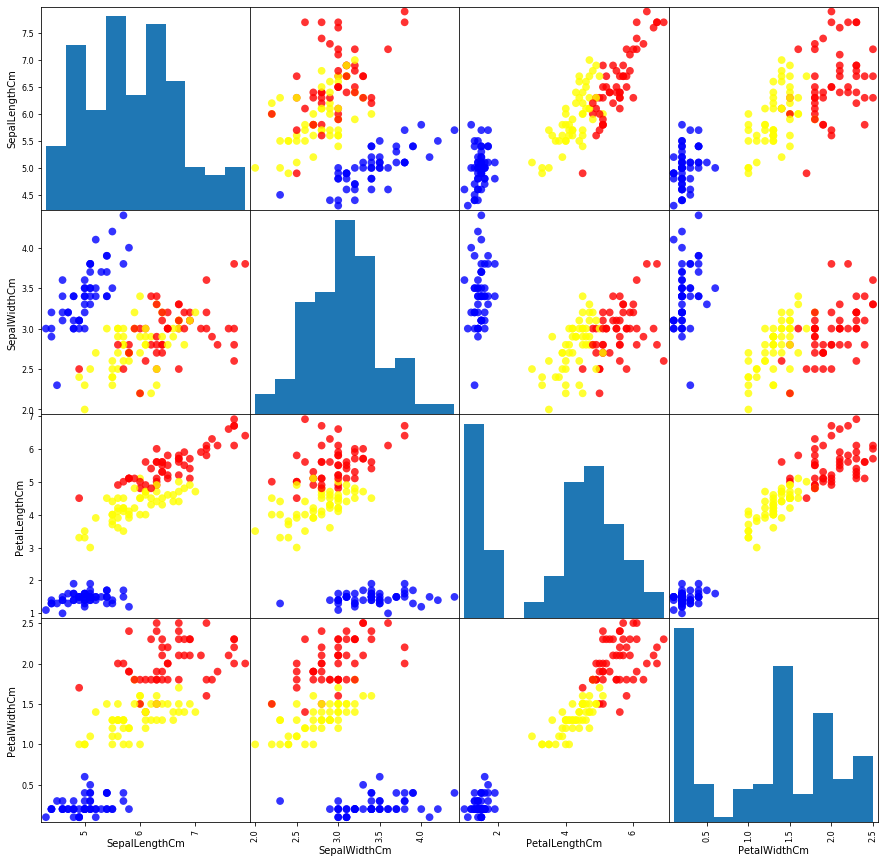

In [1]:
import os
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing 
import math
import warnings

'''
My Own Algorithms Import
'''
from preprocessing.scaler import MinMaxScaler, StandardScaler
from preprocessing.pca import PCA
from supervisedLearningAlgorithms.knn import KNN
from analysis.measure import ConfusionMatrix, ROC


#Ignore Warnings
warnings.filterwarnings("ignore")

#read data
iris_data = pd.read_csv('data-sets/iris.csv')

#randomize data with given seed
iris_data = iris_data.reindex(np.random.RandomState(seed=42).permutation(iris_data.index))
    
def assign_colors_to_iris(y_train):
    colors = []
    for row in y_train:
        assigned = "blue"
        if (row == "Iris-versicolor"):
            assigned = "yellow"
        elif(row == "Iris-virginica"):
            assigned = "red"
        colors.append(assigned)
    return colors
pd.plotting.scatter_matrix(iris_data[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]], marker='o', s=60, alpha=0.8, figsize=(15, 15), color=assign_colors_to_iris(iris_data['Species']))
plt.show()

## Analyze the Data

In [2]:
iris_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 73 to 102
Data columns (total 6 columns):
Id               150 non-null int64
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 8.2+ KB


In [3]:
iris_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
73,74,6.1,2.8,4.7,1.2,Iris-versicolor
18,19,5.7,3.8,1.7,0.3,Iris-setosa
118,119,7.7,2.6,6.9,2.3,Iris-virginica
78,79,6.0,2.9,4.5,1.5,Iris-versicolor
76,77,6.8,2.8,4.8,1.4,Iris-versicolor


## Set up Data

In [4]:
x_train, y_train = iris_data.drop(['Species'], axis=1)[:110], iris_data['Species'][:110]
x_test, y_test = iris_data.drop(['Species'], axis=1)[110:], iris_data['Species'][110:]
x_train.drop(["Id"], inplace=True, axis=1)
x_train.reset_index(drop=True, inplace=True)
x_test.drop(["Id"], inplace=True, axis=1)
x_test.reset_index(drop=True, inplace=True)

## Feature Scaling

used to normalize the range of independent variables or features of data

Initial data:

In [5]:
x_train.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,6.1,2.8,4.7,1.2
1,5.7,3.8,1.7,0.3
2,7.7,2.6,6.9,2.3
3,6.0,2.9,4.5,1.5
4,6.8,2.8,4.8,1.4


Min Max Scaler

In [6]:
min_max_scaler = MinMaxScaler((0, 1))
x_train_min_max_scaled = min_max_scaler.fit_transform(x_train)
x_train_min_max_scaled.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,0.500000,0.333333,0.627119,0.458333
1,0.388889,0.750000,0.118644,0.083333
2,0.944444,0.250000,1.000000,0.916667
3,0.472222,0.375000,0.593220,0.583333
4,0.694444,0.333333,0.644068,0.541667


Compare with SKLearn

In [7]:
min_max_scaler_scikit = preprocessing.MinMaxScaler(feature_range =(0, 1)) 
x_after_min_max_scaler = min_max_scaler_scikit.fit_transform(x_train)
x_after_min_max_scaler[:5]

array([[0.5       , 0.33333333, 0.62711864, 0.45833333],
       [0.38888889, 0.75      , 0.11864407, 0.08333333],
       [0.94444444, 0.25      , 1.        , 0.91666667],
       [0.47222222, 0.375     , 0.59322034, 0.58333333],
       [0.69444444, 0.33333333, 0.6440678 , 0.54166667]])

Standard Scalter using mean and standard deviation

In [8]:
standard_scaler = StandardScaler()
x_train_standard_scaled = standard_scaler.fit_transform(x_train)
x_train_standard_scaled.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,0.391018,-0.620663,0.600125,0.076626
1,-0.086893,1.603211,-1.051596,-1.072763
2,2.302662,-1.065438,1.811387,1.481435
3,0.271540,-0.398276,0.490011,0.459756
4,1.227362,-0.620663,0.655183,0.332046


Compare with SKLearn

In [9]:
Standardisation = preprocessing.StandardScaler() 
  
# Scaled feature 
x_after_Standardisation = Standardisation.fit_transform(x_train) 
x_after_Standardisation[:5]

array([[ 0.39101803, -0.62066321,  0.60012528,  0.07662596],
       [-0.08689289,  1.60321148, -1.05159568, -1.07276345],
       [ 2.30266171, -1.06543815,  1.81138732,  1.48143524],
       [ 0.2715403 , -0.39827574,  0.49001055,  0.45975576],
       [ 1.22736214, -0.62066321,  0.65518265,  0.33204583]])

# Principal Component Analysis

## PCA with dimension 2

Unscaled Data

No handles with labels found to put in legend.


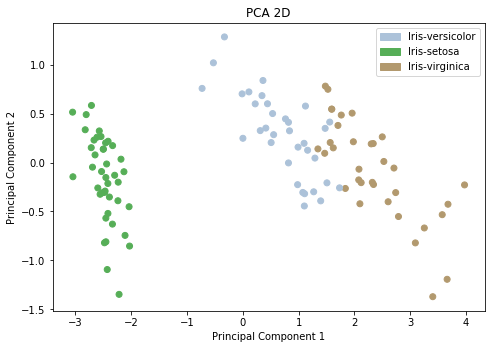

In [10]:
my_pca = PCA(2)
my_pca.fit(x_train)
pca_train_data_unscaled = my_pca.transform(x_train)
my_pca.plot("PCA 2D", y_train.values)

Min Max Scaled Data

No handles with labels found to put in legend.


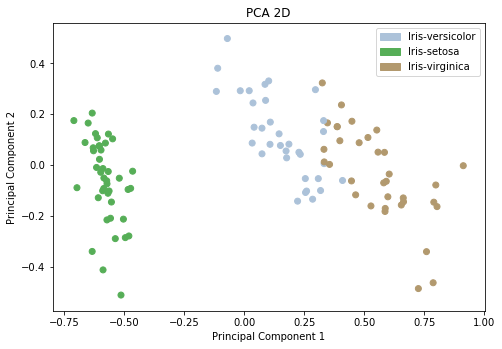

In [11]:
pca_data_min_max_scale = my_pca.fit_transform(x_train_min_max_scaled)
my_pca.plot("PCA 2D", y_train.values)

No handles with labels found to put in legend.


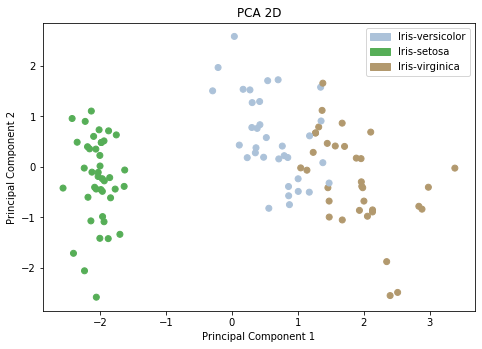

In [12]:
pca_train_data = my_pca.fit_transform(x_train_standard_scaled)
my_pca.plot("PCA 2D", y_train.values)

## Compare with SK Learn Algorithm

In [13]:
pca_train_data.head()

,Principal Component 1,Principal Component 2
0,0.764400,0.408703
1,-1.695730,-1.337247
2,3.378617,-0.027497
3,0.793125,0.218549
4,1.378596,0.079924


SKLearn result

In [14]:
from sklearn import decomposition
  
pca = decomposition.PCA(n_components = 2) 
  
pca_sklearn = pca.fit_transform(x_train_standard_scaled)[0:5]
pca_sklearn

array([[ 0.76440002, -0.40870318],
       [-1.69573024,  1.33724658],
       [ 3.3786173 ,  0.02749741],
       [ 0.79312528, -0.21854864],
       [ 1.37859647, -0.07992406]])

## PCA with dimension 3

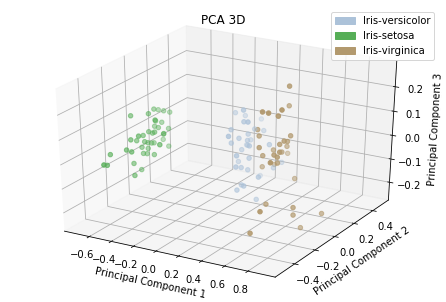

In [15]:
my_pca3 = PCA(3)
pca_data3 = my_pca3.fit_transform(x_train_min_max_scaled)
my_pca3.plot("PCA 3D", y_train.values)

## Transform Test Dimensions

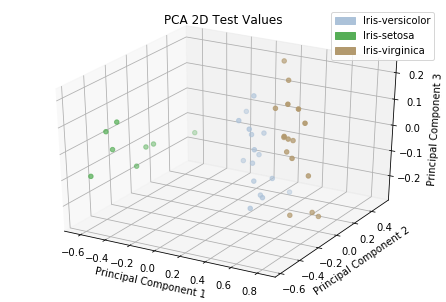

In [16]:
x_test_scaled = min_max_scaler.fit_transform(x_test)
my_pca3.fit(x_train_min_max_scaled)
pca_test_data = my_pca3.transform(x_test_scaled)
my_pca3.plot("PCA 2D Test Values", y_test.values)

## K Nearest Neighbours

In [17]:
knn = KNN(9)

knn.fit(pca_data_min_max_scale, y_train.values)
knn_results_2d = []

for k, sample in pca_test_data.iterrows():
    knn_val = knn.predict(sample)
    knn_results_2d.append(knn_val)
    
knn.fit(pca_data3, y_train.values)
knn_results_3d = []

for k, sample in pca_test_data.iterrows():
    knn_val = knn.predict(sample)
    knn_results_3d.append(knn_val)

# Analyze results

## Confusion Matrix 2D Min Max Scaled Data

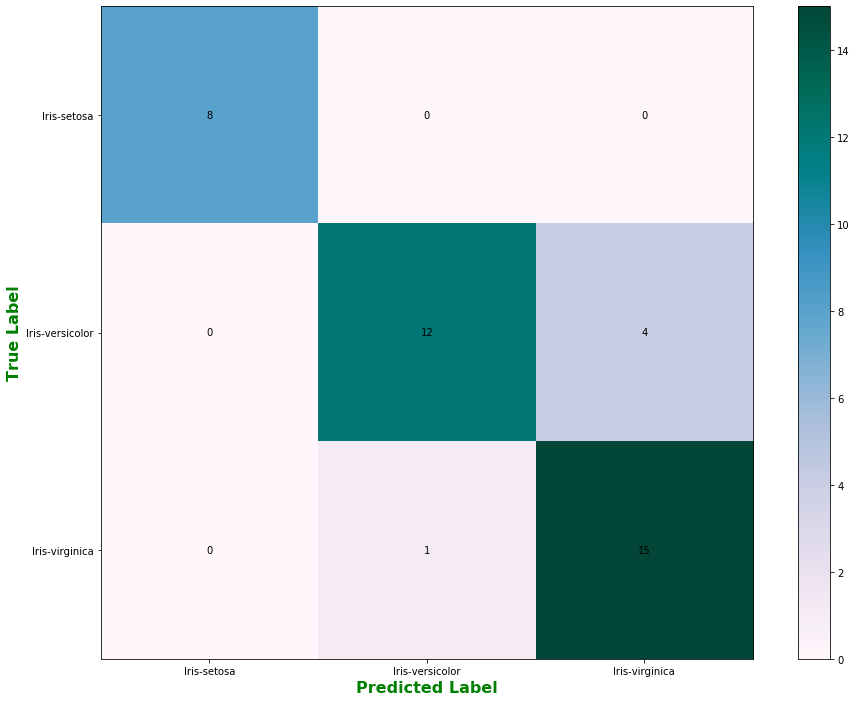

In [18]:
confusion_matrix = ConfusionMatrix()
confusion_matrix.fit(knn_results_2d, y_test.values)
confusion_matrix.plot()

## Confusion Matrix 3D Min Max Scaled Data

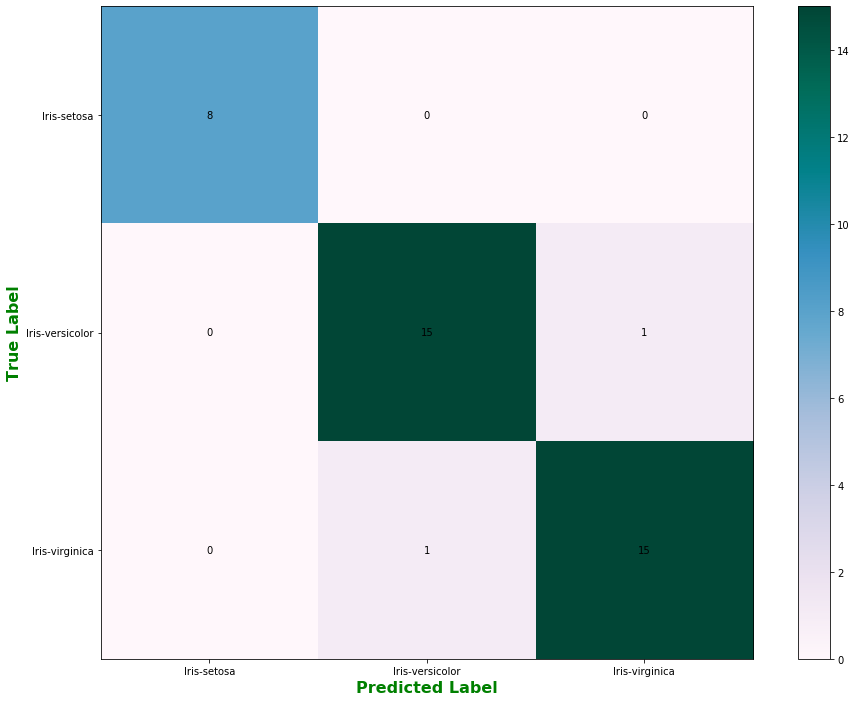

In [19]:
confusion_matrix = ConfusionMatrix()
confusion_matrix.fit(knn_results_3d, y_test.values)
confusion_matrix.plot()

In [20]:
confusion_matrx_measurements = confusion_matrix.measure("Iris-virginica")
confusion_matrx_measurements

{'True Positives': 15,
 'False Negatives': 1,
 'True Negatives': 23,
 'False Positives': 1}

In [21]:
print("Confusion Matrix label measurements for Iris-virginica")
print("Accuracy rate", confusion_matrix.accuracy_rate())
print("Error rate", confusion_matrix.error_rate())
print("Recall", confusion_matrix.recall())
print("False Positive Rate", confusion_matrix.false_positive_rate())
print("True Negative Rate", confusion_matrix.true_negative_rate())
print("Precision", confusion_matrix.precision())
print("Prevalence", confusion_matrix.prevalence())
print("Matthews Correlation Coefficient", confusion_matrix.matthews_correlation_coefficient())

Confusion Matrix label measurements for Iris-virginica
Accuracy rate 0.95
Error rate 0.050000000000000044
Recall 0.9375
False Positive Rate 0.041666666666666664
True Negative Rate 0.0625
Precision 0.9375
Prevalence 0.4
Matthews Correlation Coefficient 0.8958333333333334


Compare with SKLearn confusion Matrix

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.values, knn_results_3d, np.unique(y_test.values))
cm

NameError: name 'knn_results' is not defined

## ROC Curve

In [ ]:
roc = ROC()
iri_versicolor_probabilities_scores = []
iri_virginica_probabilities_scores = []
iris_setosa_probabilities_scores = []
roc1_label = "Iris-versicolor"
roc2_label = "Iris-virginica"
roc3_label = "Iris-setosa"

for k, sample in pca_test_data.iterrows():
    iris_versicolor_probability = knn.predict_probability(sample, roc1_label)
    iris_virginica_probability = knn.predict_probability(sample, roc2_label)
    iris_setosa_probability = knn.predict_probability(sample, roc3_label)
    iri_versicolor_probabilities_scores.append(iris_versicolor_probability)
    iri_virginica_probabilities_scores.append(iris_virginica_probability)
    iris_setosa_probabilities_scores.append(iris_setosa_probability)
    
roc.plot(roc1_label, iri_versicolor_probabilities_scores, y_test.values)
roc.plot(roc2_label, iri_virginica_probabilities_scores, y_test.values, color="red")
roc.plot(roc3_label, iris_setosa_probabilities_scores, y_test.values, color="green")
plt.show()

Compare ROC Curve with SKLearn 

In [ ]:
from sklearn import metrics
ve_fpr, ve_tpr, ve_thresholds = metrics.roc_curve([1 if (y_test.values[i] == roc1_label) else 0 for i in range(len(y_test.values))], [1 if (knn_results[i] == roc1_label) else 0 for i in range(len(knn_results))])
plt.plot(ve_fpr, ve_tpr, color="blue")
vi_fpr, vi_tpr, vi_thresholds = metrics.roc_curve([1 if (y_test.values[i] == roc2_label) else 0 for i in range(len(y_test.values))], [1 if (knn_results[i] == roc2_label) else 0 for i in range(len(knn_results))])
plt.plot(vi_fpr, vi_tpr, color="red")
s_fpr, s_tpr, s_thresholds = metrics.roc_curve([1 if (y_test.values[i] == roc3_label) else 0 for i in range(len(y_test.values))], [1 if (knn_results[i] == roc3_label) else 0 for i in range(len(knn_results))])
plt.plot(s_fpr, s_tpr, color="green")
plt.xlabel("False Positive Rate", color="black", fontsize=12)
plt.ylabel("True Positive Rate", color="black", fontsize=12)
plt.show()